<a href="https://colab.research.google.com/github/LanaSina/NCA_self_replication/blob/main/Evolution_in_Neural_Cellular_Automata_ALife_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolution in Neural Cellular Automata

This notebook contains code to reproduce experiments and figures for the ["Evolution in Neural Cellular Automata"](insert github here) project. Publication: link to paper

This project is based on the code of [Growing Neural Cellular Automata](https://distill.pub/2020/growing-ca/) by Mordvintsev, et al., "Growing Neural Cellular Automata", Distill, 2020.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# General Setup

Please run all the following cells.

In [1]:
#@title Imports and Notebook Utilities

import os
import io
import PIL.Image, PIL.ImageDraw
# from PIL import Image as pilImage
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import glob
from google.colab import files


import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  img = Image(data=imencode(a, fmt))
  display(img)

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

In [2]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8 
POOL_SIZE = 1024
# controls stochastic update rule
CELL_FIRE_RATE = 0.5 # normally 0.5, use 1 for synchronous update


In [3]:

from re import X
#@title CA Model and Utilities

from tensorflow.keras.layers import Conv2D

def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

# lizard moved to 
# https://github.com/googlefonts/noto-emoji/blob/b1246768dbcf9ccbadc95fdc57252997cb3b9d18/png/128/emoji_u1f98e.png
def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)


def to_rgba(x):
  return x[..., :4]

def to_alpha(x):
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

def get_living_mask(x):
  alpha = x[:, :, :, 3:4]
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME')  > 0.1

def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = tf.keras.Sequential([
          Conv2D(128, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.random_uniform_initializer), #zeros_initializer
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    h = x.shape[0]
    w = x.shape[1]
    initial_shape = x.shape
    # sometimes everything is none for no reason
    # when calling ca save for the 1st time
    if h is None and w is None:
      # do nothing
      h = 0
      w = 0
    elif h is None or h<=1:
      # several x in one batch
      h = x.shape[1]
      w = x.shape[2]
      x = tf.concat([x,x,x], 1)
      x = tf.concat([x,x,x], 2)
      x = x[:, h-1:2*h+1, w-1:2*w+1, :]
    else:
      w = x.shape[1]
      x = tf.concat([x,x,x], 0)
      x = tf.concat([x,x,x], 1)
      x = x[h-1:2*h+1, w-1:2*w+1, :]

    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle)
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    x += dx * tf.cast(update_mask, tf.float32)

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    x = x * tf.cast(life_mask, tf.float32)

    # periodic boundaries
    if initial_shape[1] is None:
      # do nothing
      temp = 0
    elif initial_shape[0] is None or initial_shape[0] <= 1:
      x = x[:, 1:h+1, 1:w+1, :]
    else:
      x = x[1:h+1, 1:w+1, :]

    return x

# return [numpy array, tf tensor] target with pattern in the center
# terrain_h, w: entire terrain size (>=pattern size)
def get_centered_targets(terrain_h, terrain_w, pattern):
  img_h, img_w, img_c = pattern.shape

  terrain = np.zeros([terrain_h, terrain_w, img_c], np.float32)
  x = (terrain_w - img_w)//2
  y = (terrain_h - img_h)//2
  terrain[y:y+img_h, x:x+img_w, :] = pattern
  # imshow(zoom(to_rgb(terrain), 2), fmt='png')

  return [terrain, tf.convert_to_tensor(terrain)]

In [4]:
#@title Train Utilities (SamplePool, Model Export)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(to_rgb(pool.x[:49]))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72) 
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()


In [5]:
#@title Losses etc
@tf.function
def loss_f(x, target):
  return tf.reduce_mean(tf.square(to_rgba(x)-target), [-2, -3, -1])

@tf.function
def loss_energy(x, energy_cst):
  # return batch of losses
  # sum r
  # sum last channel
  s = tf.reduce_sum(x[:,:,:,0], [1,2]) 
  loss = tf.square(energy_cst - s) 

  return loss


# seed loss tf.reduce_mean(tf.square(seed_pool-seed), [3,2,1])
def batch_loss(x, target, seed_loss):
  half_batch = int(BATCH_SIZE/2)

  # first x should be like target
  # todo reduce mean not needed?
  # TODO test this loss propoerly
  m = tf.reduce_mean(tf.square(to_rgba(x[0:half_batch])-target), [-2, -3, -1])
  # other xs should be different from target
  mm = tf.reduce_sum(tf.square(to_rgba(x[half_batch:])-target), [-2, -3, -1])
  # tf.math.reduce_variance
  # ideal error
  # how far are these from the "ideal" error
  mm = tf.square((mm/1000 - seed_loss[half_batch:])/1000)
  # m should be low, mm should be big
  total = tf.concat([m, mm], 0)
  # total = tf.reduce_mean(m - mm)
  return total

# does not check fish surroundings
# todo check
def loss_mask(x, target):
  sub_i = [int(h/2 - img_h/2), int(h/2 + img_h/2), int((w-img_w)/2), int((w+img_w)/2)]
  return tf.reduce_mean(tf.square(to_rgba(x)[:, sub_i[0]:sub_i[1], sub_i[2]:sub_i[3]] - target[sub_i[0]:sub_i[1], sub_i[2]:sub_i[3]]), [-2, -3, -1])

# another loss function, that only cares about shape
def loss_s(x, target):
  # c_index = 1
  # to_rgba is x[..., :4]
  # to_alpha is tf.clip_by_value(x[..., 3:4], 0.0, 1.0)
  # to rgb is: 1.0-a+rgb; rgb, a = x[..., :3], tf.clip_by_value(x[..., 3:4], 0.0, 1.0)
  # only B channel has to be correct
  return tf.reduce_mean(tf.square(to_rgba(x)[..., 1:4:2] - target[..., 1:4:2]))

# a selection function to reset the loop
def bacteria_select(batch):
  # select top bacteria
  batch.x[:, h//2:h, :, :] = 0
  return 

# an array of seeds, will be developped like a batch
# return developped batch
def develop_seeds(seeds):
  p = TARGET_PADDING
  # x = np.zeros([1, terrain_size[0], terrain_size[1], CHANNEL_N], np.float32)
  # ty0 = p + (img_h-egg_size)//2
  # tx0 = (w - egg_size)//2
  # x[0, ty0:ty0+egg_size, tx0:tx0+egg_size, :] = seeds[0]
  # ty0 = p*2 + img_h + (img_h-egg_size)//2
  # x[0, ty0:ty0+egg_size, tx0:tx0+egg_size, :] = seeds[1]
  n = seeds.shape[0]
  h = p*2+img_h
  w = p*2+img_w
  x = np.zeros([n, h, w, CHANNEL_N], np.float32)
  for i in range(n):
    x[i] = get_target(h, w, seeds[i])

  for i in range(96):
    x = ca(x)

  return x


def emoji_batch_loss(batch, targets):
  total_loss = 0
  for emoji, target in zip(batch, targets):
    rgb_emoji = to_rgb(emoji)
    total_loss = total_loss + np.sum(np.abs(rgb_emoji-target))

  return total_loss


# old_seeds are the n seeds in an array, shape = [n,h,w,16]
# targets are the final rgb image + padding
# just look for the most convenient dnas.
def find_best_seed(ca, old_seeds, targets):
  # Seed: Eggs in the middle
  best_seeds = np.copy(old_seeds) # np.zeros([h, w, CHANNEL_N], np.float32)
  p = TARGET_PADDING
  # target = to_rgb(np_targets[0])

  # generations
  gen = 50
  n_pop = 10
  best_loss = -1
  n_seeds = old_seeds.shape[0]
  for i in range(gen):
    if best_loss<0:
      emoji_batch = develop_seeds(best_seeds)
      # imshow(zoom(rgb_best_emojis, 2), fmt='png')
      best_loss = emoji_batch_loss(emoji_batch, targets)

    # get some children
    for p in range(n_pop):    
      # randomly modify egg
      # -1 to 1, * attenuate
      noise = np.random.rand(n_seeds, egg_size, egg_size, CHANNEL_N)*2-1
      new_seeds = old_seeds+noise*0.01
      new_seeds = np.clip(new_seeds, -1.0, 1.0)

      # develop the phenotype
      emoji_batch = develop_seeds(best_seeds)
      loss = emoji_batch_loss(emoji_batch, targets)

    if best_loss<0 or best_loss>loss:
      best_loss =  loss
      # print(i, loss)
      best_seeds = np.copy(new_seeds)
      # for seed, emoji in zip(best_seeds, emoji_batch):
      #   imshow(zoom(to_rgb(seed), 2), fmt='png')
      #   imshow(zoom(to_rgb(emoji), 2), fmt='png')

  return best_seeds

# Training

## Self replication

In [138]:
from numpy.random.mtrand import wald
#@title Setup functions (Run this as well) {vertical-output: true}

def setup_bacteria(np_targets, tf_targets):
  TARGET_EMOJI = "🦠"
  target_img = load_emoji(TARGET_EMOJI)
  img_h, img_w = target_img.shape[:2]
  p = TARGET_PADDING
  terrain_size = [p*2+img_h*2, p*2+img_w*2]
  h = terrain_size[0]
  w = terrain_size[1]

  # Seed: Bacteria
  target = get_centered_targets(terrain_size[0], terrain_size[1], target_img)
  seed = np.zeros([h, w, CHANNEL_N], np.float32)
  seed[:,:,:4]= target[0]

  # 2 bacteria
  pattern = np.zeros([img_h*2, img_w, 4], np.float32)
  pattern[:img_h, :img_w, :] = target_img
  pattern[img_h:img_h*2, :img_w, :] = target_img
  target = get_centered_targets(terrain_size[0], terrain_size[1], pattern)
  np_targets.append(target[0])
  tf_targets.append(target[1])

  # value of the max training step: 1000
  max_train_step = 1000
  ca_age = 96
  explanation = "Self replication: A -> 2A. The self replication will fail \n \
  beyond 2A, as the actual output of the NCA will be slightly different from 2A \n \
  and the replication function expects exacly A."

  result = {"max_train_step": max_train_step,
            "ca_age":ca_age,
            "explanation": explanation,
            "seed": seed,
            "h": h,
            "w": w,
            "img_h": img_h,
            "img_w": img_w,
            }
  return result

def setup_bacteria_loop(np_targets, tf_targets):
  result = setup_bacteria(np_targets, tf_targets)
  h = result["h"]
  w = result["w"]
  img_h = result["img_h"]
  img_w = result["img_w"]
   
  # cut location and size for looping
  cut_x = 0
  # cut the bottom bacteria
  cut_y = h//2
  # paste it in the middle
  paste_x = 0
  paste_y = (h - img_h)//2
  cut_size_x = w
  cut_size_y = img_h

  explanation = "Self replication: A -> 2A* -> 4A**. The self replication now \n \
  also accepts variations on A, thanks to replacing half the seed batch with \n \
  the NCA's own output. The bacteria selected for replication is chosen at \n \
  random between the top and bottom bacteria."
  result["explanation"] = explanation
  result["cut_x"] = cut_x
  result["cut_y"] = cut_y
  result["paste_x"] = paste_x
  result["paste_y"] = paste_y
  result["cut_size_x"] = cut_size_x
  result["cut_size_y"] = cut_size_y
  result["alternate"] = True

  return result


def setup_fish(np_targets, tf_targets):
  # sequence of np targets
  #? batch_np_targets = []
  TARGET_EMOJI = "🐠"
  egg_size = 6
  # 2x as many targets
  max_train_step = 2000
  ca_age = 96

  target_img = load_emoji(TARGET_EMOJI)
  img_h, img_w = target_img.shape[:2]
  p = TARGET_PADDING
  terrain_size = [p*2+img_h, p*2+img_w*2]
  h = terrain_size[0]
  w = terrain_size[1]

  # Seed: Egg in the middle
  seed = np.zeros([h, w, CHANNEL_N], np.float32)
  ty0 = (h - egg_size)//2
  tx0 = (w - egg_size)//2
  # all colors are 0 = black, alpha = live
  seed[ty0:ty0+egg_size, tx0:tx0+egg_size, 3] = 1.0

  #fish in the middle of the image
  target = get_centered_targets(terrain_size[0], terrain_size[1], target_img)
  np_targets.append(target[0])
  tf_targets.append(target[1])

  # fish slightly to the left, with an egg on the right
  large_w = img_w+egg_size+30
  pattern = np.zeros([img_h, large_w, 4], np.float32)
  pattern[:img_h, :img_w, :] = target_img
  temp_h = (img_h-egg_size)//2
  pattern[temp_h: temp_h+egg_size, img_w+5:img_w+5+egg_size, 3] = 1.0
  target = get_centered_targets(terrain_size[0], terrain_size[1], pattern)
  np_targets.append(target[0])
  tf_targets.append(target[1])

  # new seed location and size for looping
  paste_x = (terrain_size[1] - egg_size)//2
  paste_y = (terrain_size[0] - egg_size)//2
  cut_x = img_w+5+(terrain_size[1] - (img_w+egg_size+30))//2
  cut_y = (terrain_size[0] - egg_size)//2
  cut_size_x = egg_size
  cut_size_y = egg_size

  explanation = "Self replication with growth phase. There is one additional \n \
  intermediary target compared to previous experiments."
  result = {"max_train_step": max_train_step,
            "ca_age":ca_age,
            "explanation": explanation,
            "seed": seed,
            "h": h,
            "w": w,
            "img_h": img_h,
            "img_w": img_w,
            }
  
  result["cut_x"] = cut_x
  result["cut_y"] = cut_y
  result["paste_x"] = paste_x
  result["paste_y"] = paste_y
  result["cut_size_x"] = cut_size_x
  result["cut_size_y"] = cut_size_y
  result["alternate"] = False
  result["target_img"] = target_img

  return result

def setup_fish_lizard(np_targets, tf_targets):

  egg_size = 6
  fish_emoji = "🐠"
  lizard_emoji = "🦎"
  max_train_step = 4000
  p = TARGET_PADDING
  fish_img = load_emoji(fish_emoji)
  lizard_img = load_emoji(lizard_emoji)
  img_h, img_w = fish_img.shape[:2]

  terrain_size = [p*3+2*img_h, p*3+img_w*3]
  h = terrain_size[0]
  w = terrain_size[1]

  # Seed: Eggs in the middle
  seed = np.zeros([h, w, CHANNEL_N], np.float32)
  ty0 = p + (img_h-egg_size)//2
  tx0 = (w - egg_size)//2
  seed[ty0:ty0+egg_size, tx0:tx0+egg_size, 3] = 1
  # DNA
  seed[ty0:ty0+egg_size, tx0:tx0+egg_size, 0] = 0.5
  ty0 = p*2 + img_h + (img_h-egg_size)//2
  seed[ty0:ty0+egg_size, tx0:tx0+egg_size, 3] = 1.0
  seed[ty0:ty0+egg_size, tx0:tx0+egg_size, 1] = 0.5
  imshow(zoom(to_rgb(seed), 2), fmt='png')

  #organisms in the middle of the image
  pattern = np.zeros([h, w, 4], np.float32)
  ty0 = p
  tx0 = (w - img_w)//2
  pattern[ty0:ty0+img_h, tx0:tx0+img_w, :] = fish_img
  ty0 = p*2 + img_h
  tx0 = (w - img_w)//2
  pattern[ty0:ty0+img_h, tx0:tx0+img_w, :] = lizard_img
  imshow(zoom(to_rgb(pattern), 2), fmt='png')
  np_targets.append(pattern)
  tf_targets.append(tf.convert_to_tensor(pattern))

  # fish slightly to the left, with an egg on the right
  pattern = np.zeros([h, w, 4], np.float32)
  ty0 = p
  large_w = (w//2)-img_w 
  pattern[ty0:ty0+img_h, large_w:large_w+img_w, :] = fish_img
  temp_h = (img_h-egg_size)//2
  temp_w = large_w + img_w + 5
  pattern[ty0+temp_h: ty0+temp_h+egg_size, temp_w:temp_w+egg_size, 3] = 1.0
  pattern[ty0+temp_h: ty0+temp_h+egg_size, temp_w:temp_w+egg_size, 0] = 0.5
  # lizard
  ty0 = p*2 + img_h
  large_w = (w//2)-img_w 
  pattern[ty0:ty0+img_h, large_w:large_w+img_w, :] = lizard_img
  temp_h = (img_h-egg_size)//2
  temp_w = large_w + img_w +5
  pattern[ty0+temp_h: ty0+temp_h+egg_size, temp_w:temp_w+egg_size, 3] = 1.0
  pattern[ty0+temp_h: ty0+temp_h+egg_size, temp_w:temp_w+egg_size, 1] = 0.5

  # imshow(zoom(to_rgb(pattern), 2), fmt='png')
  np_targets.append(pattern)
  tf_targets.append(tf.convert_to_tensor(pattern))

  # new seed location and size for looping
  paste_x = (w - egg_size)//2
  paste_y_f = p + (img_h-egg_size)//2
  cut_x = large_w + img_w +5
  cut_y_f = p+temp_h
  paste_y_l = p*2 + img_h + (img_h-egg_size)//2
  cut_y_l = p*2 + img_h+(img_h-egg_size)//2

  test = np.zeros([terrain_size[0], terrain_size[1], 4], np.float32)
  test[paste_y_f:paste_y_f+egg_size, paste_x:paste_x+egg_size, :] = pattern[cut_y_f:cut_y_f+egg_size, cut_x:cut_x+egg_size, :]
  test[paste_y_l:paste_y_l+egg_size, paste_x:paste_x+egg_size, :] = pattern[cut_y_l:cut_y_l+egg_size, cut_x:cut_x+egg_size, :]
  #test[cut_y:cut_y+egg_size, cut_x:, :] = np_targets[1][cut_y:cut_y+egg_size, cut_x:, :]
  # imshow(zoom(to_rgb(test), 2), fmt='png')

  # new seed location and size for looping
  cut_size = egg_size

  explanation = "Self replication with 2 organisms."
  result = {"max_train_step": max_train_step,
            "ca_age":ca_age,
            "explanation": explanation,
            "seed": seed,
            "h": h,
            "w": w,
            "img_h": img_h,
            "img_w": img_w,
            }
  
  result["cut_x"] = cut_x
  result["cut_y"] = cut_y
  result["paste_x"] = paste_x
  result["paste_y_f"] = paste_y_f
  result["paste_y_l"] = paste_y_l
  result["cut_y_f"] = cut_y_f
  result["cut_y_l"] = cut_y_l
  result["cut_size"] = cut_size
  result["alternate"] = False

  return result



Self replication with growth phase. There is one additional 
   intermediary target compared to previous experiments.
Seed


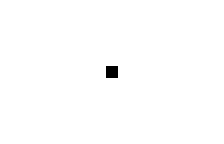

Targets


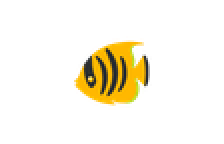

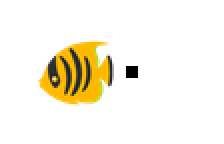

In [156]:
#@title Pick an experiment
# replace with emoji
EXPERIMENT_TYPE = "Fish" #@param ["Bacteria Simple", "Bacteria Loop", "Fish", "Fish and Lizard", "Fish Competition"]

# display explanation here
# run the setup
np_targets = []
tf_targets = []
expl = ""
looping = False
noise = False

if EXPERIMENT_TYPE == "Bacteria Simple":
  param_dict = setup_bacteria(np_targets, tf_targets)
elif EXPERIMENT_TYPE == "Bacteria Loop":
  param_dict = setup_bacteria_loop(np_targets, tf_targets)
  looping = True
elif EXPERIMENT_TYPE == "Fish":
  param_dict = setup_fish(np_targets, tf_targets)
  looping = True
elif EXPERIMENT_TYPE == "Fish Competition":
  param_dict = setup_fish(np_targets, tf_targets)
  looping = True
  noise = True
elif EXPERIMENT_TYPE == "Fish and Lizard":
  param_dict = setup_fish_lizard(np_targets, tf_targets)
  looping = True


print(param_dict["explanation"])
seed = param_dict["seed"]
print("Seed")
imshow(zoom(to_rgb(seed), 2), fmt='png')
print("Targets")
for i in range(len(np_targets)):
  imshow(zoom(to_rgb(np_targets[i]), 2), fmt='png')


batch (before/after):


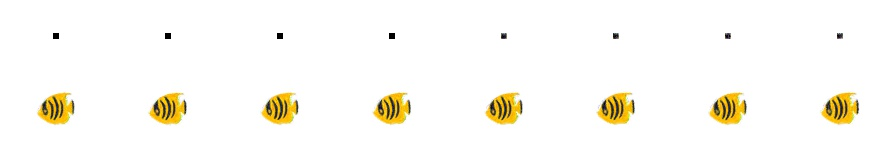

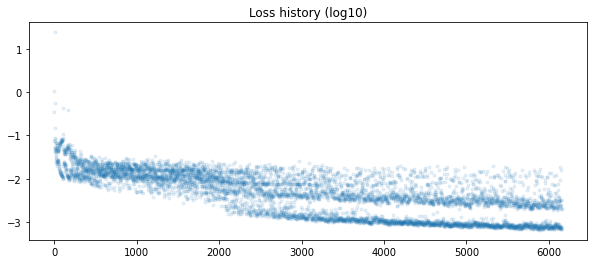

 step: 6155, log10(loss): -3.165, cut: 0.000

In [102]:
#@title Train the model (single organism) {vertical-output: true}

reset = False
BATCH_SIZE = 8 
h = param_dict["h"]
w = param_dict["w"]
ca_age = param_dict["ca_age"]

if reset:
  # reset everything after an experiment
  ca = CAModel()
  loss_log = []
  loss_e_log = []
  loss0 = tf.reduce_mean(loss_f(seed, tf_targets[0]).numpy())
  # store seeds without creating new tensors (?)
  # one pool per target
  pools = []
  pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
  pools.append(pool)

  lr = 2e-3
  lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [2000], [lr, lr*0.1])
  trainer = tf.keras.optimizers.Adam(lr_sched)
  trainer_ene = tf.keras.optimizers.Adam(lr_sched)

  !mkdir -p train_log && rm -f train_log/*

  for i in range(len(np_targets)-1):
    target = np_targets[i]
    contents = np.zeros((h,w,CHANNEL_N), np.float32)
    contents[:,:,:4] = np.copy(target)
    pool = SamplePool(x=np.repeat(contents[None, ...], POOL_SIZE, 0))
    pools.append(pool)


# Training Loop 
@tf.function
def train_step(x, target):
  iter_n = param_dict["ca_age"]
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x, target))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

if looping:
  img_h = param_dict["img_h"]
  img_w = param_dict["img_w"]
  cut_x = param_dict["cut_x"]
  cut_y = param_dict["cut_y"]
  paste_x = param_dict["paste_x"]
  paste_y = param_dict["paste_y"]
  cut_size_x = param_dict["cut_size_x"]
  cut_size_y = param_dict["cut_size_y"]
  max_steps = param_dict["max_train_step"]
  alternate = param_dict["alternate"]
  # number of stages
  n_stages = len(pools)
  stage = 0
  cut = 0

  # avoid doing this in loop
  seed_batch = np.repeat(np.copy(seed[None, ...]), BATCH_SIZE, 0)
  empty_batch = np.zeros((BATCH_SIZE, h, w, CHANNEL_N))
  
  for i in range(max_steps+1):
    if stage == n_stages:
      stage = 0

    target = np_targets[stage]
    # seed stages
    batch = pools[stage].sample(BATCH_SIZE)
    x0 = batch.x

    if stage == 0: # from egg to org
      # replace half the batch with clean seeds
      np.copyto(x0[:BATCH_SIZE//2], seed_batch[:BATCH_SIZE//2])
    else:
      np.copyto(x0[:BATCH_SIZE//2], empty_batch[:BATCH_SIZE//2])
      x0[:BATCH_SIZE//2,:,:,:4] = np_targets[0]
      # add noise on the dividing process only
      if noise:
        # paste a fish at some random position
        rpos = np.random.random((2))*[TARGET_PADDING*2, TARGET_PADDING*2] 
        rpos = rpos - [TARGET_PADDING, TARGET_PADDING] 
        rpos = rpos + [h//2-img_h//2, w//2-img_w//2]
        rpos = rpos.astype(int)
        rpos_end = rpos+[img_h, img_w]
        rpos_end = rpos_end.astype(int)
        x0[BATCH_SIZE//2: , rpos[0]:rpos_end[0], rpos[1]:rpos_end[1], :4] +=\
        np.repeat(np.copy(target_img[None, ...]), BATCH_SIZE//2, 0)

    x, loss = train_step(x0, target)

    next_stage = (stage+1)%n_stages
    next_batch = pools[next_stage].sample(BATCH_SIZE)
    # if stage is not the last
    # eg, stage 0 is the last stage if n = 1
    if stage + 1 < n_stages:
      cut = 0
      # commit as the start point of next stage
      next_batch.x[:] = x 
      next_batch.commit()
    else:
      # last stage
      cut = 1
      # save to use as seeds later
      np.copyto(next_batch.x, empty_batch)
      # copy results at the appropritate place
      cut_pattern = x[:, cut_y:cut_y+cut_size_y, cut_x:cut_x+cut_size_x, :]
      if alternate:
        if np.random.random()<0.5:
          cut_pattern = x[:, cut_y-cut_size_y:cut_y, cut_x:cut_x+cut_size_x, :]
      np.copyto(next_batch.x[:, paste_y:paste_y+cut_size_y, paste_x:paste_x+cut_size_x, :],
                cut_pattern)
      next_batch.commit()
  
    loss_log.append(loss.numpy())
    
    if i%10 == 0:
      generate_pool_figures(pools[stage], i)
    if i%100 == 0:
      clear_output()
      visualize_batch(x0, x, i)
      plot_loss(loss_log)
      export_model(ca, 'train_log/%04d'%i)   

    stage = stage + 1
    print('\r step: %d, log10(loss): %.3f, cut: %.3f'%(len(loss_log), np.log10(loss), cut), end='')
else: 
  target = np_targets[0]
  for i in range(param_dict["max_train_step"]+1):
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    x, loss = train_step(x0, target)
    loss_log.append(loss.numpy())
    
    if i%10 == 0:
      generate_pool_figures(pool, i)
    if i%100 == 0:
      clear_output()
      visualize_batch(x0, x, i)
      plot_loss(loss_log)
      export_model(ca, 'train_log/%04d'%i)

    print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')


batch (before/after):


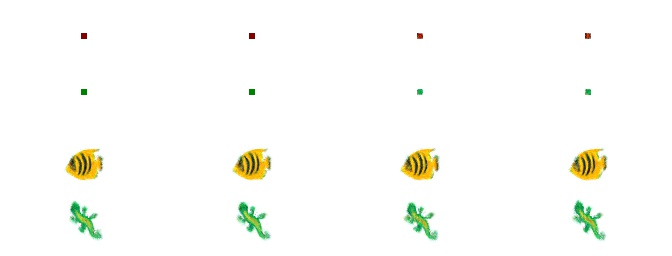

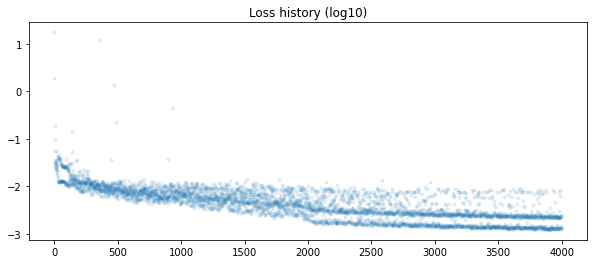

 step: 4001, log10(loss): -2.895, cut: 0.000

In [140]:
#@title Train the model (several organisms) {vertical-output: true}

reset = True
BATCH_SIZE = 4
h = param_dict["h"]
w = param_dict["w"]
ca_age = param_dict["ca_age"]

if reset:
  # reset everything after an experiment
  ca = CAModel()
  loss_log = []
  loss_e_log = []
  loss0 = tf.reduce_mean(loss_f(seed, tf_targets[0]).numpy())
  # store seeds without creating new tensors (?)
  # one pool per target
  pools = []
  pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
  pools.append(pool)

  lr = 2e-3
  lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [2000], [lr, lr*0.1])
  trainer = tf.keras.optimizers.Adam(lr_sched)
  trainer_ene = tf.keras.optimizers.Adam(lr_sched)

  !mkdir -p train_log && rm -f train_log/*

  for i in range(len(np_targets)-1):
    target = np_targets[i]
    contents = np.zeros((h,w,CHANNEL_N), np.float32)
    contents[:,:,:4] = np.copy(target)
    pool = SamplePool(x=np.repeat(contents[None, ...], POOL_SIZE, 0))
    pools.append(pool)


# Training Loop
@tf.function
def train_step(x, target):
  iter_n = param_dict["ca_age"]
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x, target))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

print(looping)

if looping:
  img_h = param_dict["img_h"]
  img_w = param_dict["img_w"]
  cut_x = param_dict["cut_x"]
  cut_y_f = param_dict["cut_y_f"]
  cut_y_l = param_dict["cut_y_l"]
  paste_x = param_dict["paste_x"]
  paste_y_f = param_dict["paste_y_f"]
  paste_y_l = param_dict["paste_y_l"]
  cut_size = param_dict["cut_size"]
  max_steps = param_dict["max_train_step"]
  alternate = param_dict["alternate"]
  # number of stages
  n_stages = len(pools)
  print(n_stages)
  stage = 0
  cut = 0

  # avoid doing this in loop
  seed_batch = np.repeat(np.copy(seed[None, ...]), BATCH_SIZE, 0)
  empty_batch = np.zeros((BATCH_SIZE, h, w, CHANNEL_N))
  
  for i in range(max_steps+1):
    if stage == n_stages:
      stage = 0

    target = np_targets[stage]
    # seed stages
    batch = pools[stage].sample(BATCH_SIZE)
    x0 = batch.x

    if stage == 0: # from egg to org
      # replace half the batch with clean seeds
      np.copyto(x0[:BATCH_SIZE//2], seed_batch[:BATCH_SIZE//2])
    else:
      np.copyto(x0[:BATCH_SIZE//2], empty_batch[:BATCH_SIZE//2])
      # np.copyto(
      x0[:BATCH_SIZE//2,:,:,:4] = np_targets[0]

    x, loss = train_step(x0, target)

    next_stage = (stage+1)%n_stages
    next_batch = pools[next_stage].sample(BATCH_SIZE)
    # if stage is not the last
    # eg, stage 0 is the last stage if n = 1
    if stage + 1 < n_stages:
      cut = 0
      # commit as the start point of next stage
      next_batch.x[:] = x 
      next_batch.commit()
    else:
      # last stage
      cut = 1
      # save to use as seeds later
      np.copyto(next_batch.x, empty_batch)
      # copy results at the appropritate place
      cut_pattern = x[:, cut_y_f:cut_y_f+cut_size_y, cut_x:cut_x+cut_size_x, :]
      np.copyto(next_batch.x[:, paste_y_f:paste_y_f+cut_size_y, paste_x:paste_x+cut_size_x, :],
                cut_pattern)
      cut_pattern = x[:, cut_y_l:cut_y_l+cut_size_y, cut_x:cut_x+cut_size_x, :]
      np.copyto(next_batch.x[:, paste_y_l:paste_y_l+cut_size_y, paste_x:paste_x+cut_size_x, :],
                cut_pattern)
      next_batch.commit()
  
    loss_log.append(loss.numpy())
    
    if i%10 == 0:
      generate_pool_figures(pools[stage], i)
    if i%100 == 0:
      clear_output()
      visualize_batch(x0, x, i)
      plot_loss(loss_log)
      export_model(ca, 'train_log/%04d'%i)   

    stage = stage + 1
    print('\r step: %d, log10(loss): %.3f, cut: %.3f'%(len(loss_log), np.log10(loss), cut), end='')
else: 
  target = np_targets[0]
  for i in range(param_dict["max_train_step"]+1):
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    x, loss = train_step(x0, target)
    loss_log.append(loss.numpy())
    
    if i%10 == 0:
      generate_pool_figures(pool, i)
    if i%100 == 0:
      clear_output()
      visualize_batch(x0, x, i)
      plot_loss(loss_log)
      export_model(ca, 'train_log/%04d'%i)

    print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')


# Figures

In [162]:
#@title If using a pretrained network, load it here
i = 4000
ca = CAModel()
ca.load_weights('train_log/%04d'%i)
# ca.load_weights('./%04d'%i)

In [141]:
#@title Make Video

VIDEO_TYPE = "Continuous" #@param ["Continuous", "Transplant"]

h = param_dict["h"]
w = param_dict["w"]
ca_age = param_dict["ca_age"]
out_fn = 'out.mp4'
video_length = ca_age*4*n_stages+1

x = np.zeros([1, h, w, CHANNEL_N], np.float32)
x[..., -h:, :, :] = np.copy(seed)

# for i in range(4000):
#   temp = ca(x)
#   x[:] = temp[0]

if VIDEO_TYPE == "Continuous":
  with VideoWriter(out_fn) as vid:
    for i in range(video_length):
      vis = np.hstack(to_rgb(x))
      vid.add(zoom(vis, 2))

      temp = ca(x)
      x[:] = temp[0]
else:
  with VideoWriter(out_fn) as vid:
    for i in range(video_length):
      vis = np.hstack(to_rgb(x))
      vid.add(zoom(vis, 2))

      if i%(ca_age*n_stages)==0:
        if i>0:
          cut_pattern = np.copy(x[:, cut_y:cut_y+cut_size_y, cut_x:cut_x+cut_size_x, :])
          if alternate:
            if np.random.random()<0.5:
              cut_pattern = np.copy(x[:, cut_y-cut_size_y:cut_y, cut_x:cut_x+cut_size_x, :])
          x[0] = np.copy(empty_batch[0])
          x[:, paste_y:paste_y+cut_size_y, paste_x:paste_x+cut_size_x, :] = cut_pattern
          vis = np.hstack(to_rgb(x))
          vid.add(zoom(vis, 2))
      
      temp = ca(x)
      x[:] = temp[0]

mvp.ipython_display(out_fn)


##Extract frames

In [ ]:
#@title Extract development frames

h = param_dict["h"]
w = param_dict["w"]
ca_age = param_dict["ca_age"]
n_stages = len(np_targets)

x = np.zeros([1, h, w, CHANNEL_N], np.float32)
x[..., -h:, :, :] = np.copy(seed)
ca_age = param_dict["ca_age"]

save_path = "img/"
!rm -rf img
!mkdir img 
# file_name = save_path + "t_0.png"
# plt.imsave(file_name, seed[:,:,:4])

for i in range(ca_age*n_stages+1):
  index = '%03d'%i
  file_name = save_path + "t_" + index + ".png"
  imshow(zoom(to_rgb(x[0]), 2), fmt='png')

  img = to_rgb(x[0])*255
  img = np.clip(img.numpy(), 0, 255).astype(np.uint8)
  image = PIL.Image.fromarray(img)
  image.save(file_name, format='PNG')

  temp = ca(x)
  x[:] = temp[0]


In [ ]:
#@title Extract replication frames

# tf.compat.v1.enable_eager_execution()

h = param_dict["h"]
w = param_dict["w"]
ca_age = param_dict["ca_age"]
n_stages = len(np_targets)
img_h = param_dict["img_h"]
img_w = param_dict["img_w"]
cut_x = param_dict["cut_x"]
cut_y = param_dict["cut_y"]
paste_x = param_dict["paste_x"]
paste_y = param_dict["paste_y"]
cut_size_x = param_dict["cut_size_x"]
cut_size_y = param_dict["cut_size_y"]
alternate = param_dict["alternate"]

empty_batch = np.zeros((BATCH_SIZE, h, w, CHANNEL_N))
x = np.zeros([1, h, w, CHANNEL_N], np.float32)

# seed for fish in fish/lizard
seed[paste_y:paste_y+cut_size_y, paste_x:paste_x+cut_size_x, 3] = 1
seed[paste_y:paste_y+cut_size_y, paste_x:paste_x+cut_size_x, 0] = 0.5
# cut for f in fl
large_w = (w//2)-img_w 
cut_x = large_w + img_w +5
x[..., -h:, :, :] = np.copy(seed)

save_path = "img/"
!rm -rf img/*
!mkdir img 



file_name = save_path + "single_000.png"
plt.imsave(file_name, seed[:,:,:4])

imshow(zoom(to_rgb(seed), 2), fmt='png')

for i in range(ca_age*5*n_stages+1):
  if i%(ca_age*n_stages)==0:
    if i>0:
      ii= i//(ca_age*n_stages)
      index = '%03d'%ii

      file_name = save_path + "double_" + str(index) + ".png"
      imshow(zoom(to_rgb(x[0]), 2), fmt='png')

      img = to_rgb(x[0])*255
      img = np.clip(img.numpy(), 0, 255).astype(np.uint8)
      image = PIL.Image.fromarray(img)
      image.save(file_name, format='PNG')
      cut_pattern = np.copy(x[:, cut_y:cut_y+cut_size_y, cut_x:cut_x+cut_size_x, :])
      if alternate:
        if np.random.random()<0.5:
          cut_pattern = np.copy(x[:, cut_y-cut_size_y:cut_y, cut_x:cut_x+cut_size_x, :])
          
      x[0] = np.copy(empty_batch[0])
      x[:, paste_y:paste_y+cut_size_y, paste_x:paste_x+cut_size_x, :] = cut_pattern
      imshow(zoom(to_rgb(x[0]), 2), fmt='png')
      
      file_name = save_path + "single_" + str(index) + ".png"

      img = to_rgb(x[0])*255
      img = np.clip(img.numpy(), 0, 255).astype(np.uint8)
      image = PIL.Image.fromarray(img)
      image.save(file_name, format='PNG')

  temp = ca(x)
  x[:] = temp[0]

## Data saving

In [ ]:
# download a folder

from google.colab import files

!rm -f file.zip

!zip -r /content/file.zip /content/img/*
files.download("/content/file.zip")

In [ ]:
# download a model
i=3000
files.download('train_log/%04d.index'%i) 
files.download('train_log/%04d.json'%i) 
files.download('train_log/%04d.data-00000-of-00001'%i) 

In [ ]:
# # download folder and model
# from google.colab import files

# i = 1000
# !mkdir download
# !rm -rf download/*
# !cp -r img download/

# f_name = 'train_log/%04d.index'%i
# dest_name = download
# shutil.move(f_name, "path/to/new/destination/for/file")

# !cp 'train_log/%04d.index'%i  
# files.download('train_log/%04d.json'%i) 
# files.download('train_log/%04d.data-00000-of-00001'%i) 

# !zip -r /content/file.zip /content/img
# files.download("/content/file.zip")

# files.download('train_log/%04d.index'%i) 
# files.download('train_log/%04d.json'%i) 
# files.download('train_log/%04d.data-00000-of-00001'%i) 


In [ ]:
# @title write csv

h = param_dict["h"]
w = param_dict["w"]
ca_age = param_dict["ca_age"]
n_stages = len(np_targets)
img_h = param_dict["img_h"]
img_w = param_dict["img_w"]
cut_x = param_dict["cut_x"]
cut_y = param_dict["cut_y"]
paste_x = param_dict["paste_x"]
paste_y = param_dict["paste_y"]
cut_size_x = param_dict["cut_size_x"]
cut_size_y = param_dict["cut_size_y"]
alternate = param_dict["alternate"]

# seed for fish in fish/lizard
seed[paste_y:paste_y+cut_size_y, paste_x:paste_x+cut_size_x, 3] = 1
seed[paste_y:paste_y+cut_size_y, paste_x:paste_x+cut_size_x, 0] = 0.5
# cut for f in fl
large_w = (w//2)-img_w 
cut_x = large_w + img_w +5

empty_batch = np.zeros((BATCH_SIZE, h, w, CHANNEL_N))
x = np.zeros([1, h, w, CHANNEL_N], np.float32)
x[..., -h:, :, :] = np.copy(seed)


save_path = "csv/"
!rm -rf csv/*
!mkdir csv 
max_step = 100*ca_age*n_stages
egg_path = save_path+"egg_" + str(max_step) + ".csv"
fish_path = save_path+"fish_"+ str(max_step) + ".csv"

init_egg = np.zeros((cut_size_y, cut_size_x, CHANNEL_N))
init_egg[:,:,3] = 1
n = cut_size_x*cut_size_y*CHANNEL_N

imshow(zoom(to_rgb(x[0]), 2), fmt='png')

with open(egg_path, 'w') as e, open(fish_path, 'w') as f:
  for i in range(max_step):
    if i>0 and i%(96*2)==0:
      temp_seed = np.zeros(x.shape)
      cut_pattern = np.copy(x[:, cut_y:cut_y+cut_size_y, cut_x:cut_x+cut_size_x, :])
      if alternate:
        if np.random.random()<0.5:
          cut_pattern = np.copy(x[:, cut_y-cut_size_y:cut_y, cut_x:cut_x+cut_size_x, :])

      temp_seed[:, paste_y:paste_y+cut_size_y, paste_x:paste_x+cut_size_x, :] = cut_pattern
      print(i)
      imshow(zoom(to_rgb(cut_pattern[0]), 2), fmt='png')
      temp = ca(temp_seed)
      # write csv
      np.savetxt(e, cut_pattern.reshape(1,n), fmt="%1.3f", delimiter=",", newline="\n")
    else:
      if i>0 and i%96==0: 
        temp_y = (h-img_h)//2
        temp_x = (w-img_w)//2
        fish = x[0, temp_y:temp_y+img_h, temp_x:temp_x+img_w, :]
        imshow(zoom(to_rgb(fish), 2), fmt='png')
        np.savetxt(f, fish.reshape(1,img_w*img_h*CHANNEL_N), fmt="%1.3f", delimiter=",", newline="\n")

      temp = ca(x)

    x[:] = temp[0]


In [170]:
# download csv
!rm -f file.zip

!zip -r /content/file.zip /content/csv
files.download("/content/file.zip")

  adding: content/csv/ (stored 0%)
  adding: content/csv/egg_19200.csv (deflated 70%)
  adding: content/csv/fish_19200.csv (deflated 83%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Non-repeating sequences





In [ ]:
#@title Simple Flower { vertical-output: true}
egg_size = 4

TARGET_EMOJI = "🌻"
target_img = load_emoji(TARGET_EMOJI)
img_h, img_w = target_img.shape[:2]
p = TARGET_PADDING
terrain_size = [p*2+img_h, p*2+img_w]
h = terrain_size[0]
w = terrain_size[1]

# Seed at the bottom
seed = np.zeros([h, w, CHANNEL_N], np.float32)
ty0 = (h - egg_size - p)
tx0 = (w - egg_size)//2
# all colors are 0 = black, alpha = live
seed[ty0:ty0+egg_size, tx0:tx0+egg_size, 3] = 1.0
# DNA stem leaf flower (roughly by time of development)
seed[ty0:ty0+egg_size, tx0:tx0+egg_size, 4:7] = 0.5

imshow(zoom(to_rgb(seed), 2), fmt='png')

#fish in the middle of the image
target = get_np_target(terrain_size[0], terrain_size[1], target_img)
np_target = target[0]
tf_target = target[1]

In [ ]:
#@title Several Flowers { vertical-output: true}

# list of np targets
np_targets = []
tf_targets = []
batch_np_targets = []
egg_size = 1 # 4

n = 3
emojis = ["🌷","🌻","🌹"]
target_imgs = []
for e in emojis:
  target_img = load_emoji(e)
  target_imgs.append(target_img)

img_h, img_w = target_img.shape[:2]
p = 0#TARGET_PADDING
terrain_size = [p*2+img_h, p*2+img_w*n]
h = terrain_size[0]
w = terrain_size[1]
print(h,w)

np_target = np.zeros((h,w,4), np.float32)

# Seeds at the bottom
extracted_seeds = np.zeros((n, egg_size, egg_size, CHANNEL_N))
seed = np.zeros([h, w, CHANNEL_N], np.float32)
ty0 = (h - egg_size - p)
tx0 = p + (img_w - egg_size)//2
y = h-p-img_h
for i in range(n):
  seed[ty0:ty0+egg_size, tx0:tx0+egg_size, :] = np.random.rand(egg_size, egg_size, CHANNEL_N)
  seed[ty0:ty0+egg_size, tx0:tx0+egg_size, 3] = 1.0
  extracted_seeds[i] = seed[ty0:ty0+egg_size, tx0:tx0+egg_size, :]
  tx0 = tx0 + img_w
  x = p + img_w*i 
  np_target[y:y+img_h, x:x+img_w] = target_imgs[i]
  

imshow(zoom(to_rgb(seed), 2), fmt='png')
imshow(zoom(to_rgb(np_target), 2), fmt='png')

tf_target = tf.convert_to_tensor(np_target)


In [ ]:
#@title Several Flowers (colony) { vertical-output: true}

# list of np targets
np_targets = []
tf_targets = []
batch_np_targets = []
egg_size = 1 # 4

n = 2
emojis = ["🌷","🌻"]#,"🌹"]
target_imgs = []
for e in emojis:
  target_img = load_emoji(e)
  target_imgs.append(target_img)

img_h, img_w = target_img.shape[:2]
p = TARGET_PADDING
terrain_size = [p*2+img_h, p*2+img_w*n]
h = terrain_size[0]
w = terrain_size[1]
print(h,w)


# Seeds at random (id, xy, value)
n_seeds = 10
spos = np.random.rand(n_seeds,2+CHANNEL_N)
spos[:,0] = spos[:,0]*img_h
spos[:,1] = spos[:,1]*img_w
spos[:,2:] = 0.5
spos[:,5] = 1
s2pos = np.copy(spos)

seed = np.zeros([h, w, CHANNEL_N], np.float32)
for i in range(n_seeds):
  s = spos[i]
  seed[int(s[0])+p, int(s[1])+p] = s[2:]
  
np_target = np.zeros((h,w,4), np.float32)
y = h-p-img_h
for i in range(n): 
  x = p + img_w*i  
  np_target[y:y+img_h, x:x+img_w] = target_imgs[i]
  
imshow(zoom(to_rgb(seed), 2), fmt='png')
imshow(zoom(to_rgb(np_target), 2), fmt='png')

tf_target = tf.convert_to_tensor(np_target)


# Train

## Tests

In [ ]:
# @title extract seeds
s0 = seed[paste_y_0:paste_y_0+egg_size, paste_x:paste_x+egg_size, :]
s1 = seed[paste_y_1:paste_y_1+egg_size, paste_x:paste_x+egg_size, :]
s2 = np.copy(s1)
seeds = np.array([s2])#, s1, s2])
print(seeds.shape)

h = p*2+img_h
w = p*2+img_w
t0 = get_np_target(h, w, emoji_0_img)[0]
t1 = get_np_target(h, w, emoji_1_img)[0]
t2 = get_np_target(h, w, emoji_2_img)[0]

targets = np.array([to_rgb(t2)])#, to_rgb(t1), to_rgb(t2)])

# imshow(zoom(to_rgb(seed), 2), fmt='png')
# imshow(zoom(to_rgb(s0), 2), fmt='png')
# imshow(zoom(to_rgb(s1), 2), fmt='png')


new_best = find_best_seed(ca, seeds, targets)

In [ ]:
# @title develop seeds
a = develop_seeds(new_best)
imshow(zoom(to_rgb(a[0]), 2), fmt='png')
# imshow(zoom(to_rgb(a[1]), 2), fmt='png')
# imshow(zoom(to_rgb(a[2]), 2), fmt='png')

rgb_emoji = to_rgb(a[0])
print(np.sum(np.abs(rgb_emoji-targets[0])))

## Run training

In [ ]:
#@title Training Loop (Hybrids) {vertical-output: true}
import random

@tf.function
def loss_s(x, target):
  # the last flower should be a hybrid
  rgba = to_rgba(x)
  p0 = rgba[:,:,p:p+img_w,:]
  pt0 = target[:,p:p+img_w,:]
  l0 = tf.reduce_mean(tf.square(p0-pt0))

  return l0


@tf.function
def train_step(x, target):
  # s2pos = np.zeros(spos.shape)
  iter_n = 64
  init_x = np.copy(seed)
  s2pos_np = np.copy(s2pos)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    # loss only on p0
    loss = tf.reduce_mean(loss_s(x, target))
    # try building p1
    best_s, s2pos_, best_x = arrange(init_x, s2pos_np) 
    loss = loss + tf.reduce_mean(loss_f(best_x, target))

  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss, s2pos_
  


def variate(spos):
  v = np.copy(spos)
  v[:,0:2] = v[:,0:2] + np.random.rand(n_seeds,2)*10
  v[:,0] = np.clip(v[:,0], 0, img_h)
  v[:,1] = np.clip(v[:,1], 0, img_w)
  return v

def arrange(seed, spos):
  iter_n = 64
  best_loss = None
  best_s = None
  best_var = None
  best_x = None
  nseed = np.copy(seed)
  p = TARGET_PADDING
  nseed[:,p+img_w:] = 0

  for pop in range(10):
    variation = variate(spos)
    for i in range(n_seeds):
      s = variation[i]
      nseed[int(s[0])+p, int(s[1])+p+img_w] = s[2:]

    x = nseed[None, ...]
    for i in tf.range(iter_n):
        x = ca(x)
    loss = tf.reduce_mean(loss_f(x, target))

    if (best_loss is None) or loss<best_loss:
      best_loss = loss
      best_s = nseed
      best_var = variation
      best_x = x
    
    return best_s, best_var, best_x


target = np_target
# 

for step_i in range(2000+1):

  seed[:,p+img_w:] = 0
  for i in range(n_seeds):
    s = s2pos[i]
    seed[int(s[0])+p, int(s[1])+p+img_w] = s[2:]

  x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
  x, loss, s2pos_tf = train_step(x0, target)
  s2pos[:] = s2pos_tf[:]

  loss_log.append(loss.numpy())
  
  if step_i%10 == 0:
    generate_pool_figures(pool, step_i)
  if step_i%100 == 0:
    clear_output()
    visualize_batch(x0, x, step_i)
    plot_loss(loss_log)
    export_model(ca, 'train_log/%04d'%step_i)

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

In [ ]:
arrange(seed, s2pos) 

In [ ]:
#@title Training Loop (DNA expressiveness) {vertical-output: true}

@tf.function
def loss_div(y, img_w, img_h):
  # difference between all 3 parts
  x = tf.clip_by_value(y, -1.0, 1.0)
  p0 = x[:,:,p:p+img_w,:]
  p1 = x[:,:,p+img_w:p+img_w*2,:]
  p2 = x[:,:,p+img_w*2:p+img_w*3,:]
  sum_diff = tf.square(p0-p1) + tf.square(p0-p2) + tf.square(p1-p2)
  # max difference is 2, max dist is 4
  diff = sum_diff/(3*4) 
  # max value here should be 1
  loss = tf.reduce_mean(diff)
  if (loss!=0):
    loss = 1/loss
  else:
    loss = loss + 100
  return loss

@tf.function
def train_step(x, target):
  iter_n = tf.random.uniform([], 64, 96, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x, target))
    loss_d = tf.reduce_mean(loss_div(x, img_w, img_h))
    loss = loss + loss_d
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

@tf.function
def train_divergent(x):
  with tf.GradientTape() as g:
    for i in tf.range(96):
      x = ca(x)
    loss = tf.reduce_mean(loss_div(x, img_w, img_h))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss


def update_ca(seed, target):
  x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
  x, loss = train_step(x0, target)
  loss_log.append(loss.numpy())
  return x0, x, loss


def update_divergent(seed):
  seeds = extracted_seeds
  a =  np.random.rand(seeds.shape[0], seeds.shape[1], seeds.shape[2], seeds.shape[3])
  h = terrain.shape[0]
  w = terrain.shape[1]
  ty0 = (h - egg_size - p)
  tx0 = TARGET_PADDING + (img_w - egg_size)//2
  for i in range(3):
    terrain[ty0:ty0+egg_size, tx0:tx0+egg_size, :] = a[i]
    tx0 = tx0 + img_w

  x0 = np.repeat(terrain[None, ...], BATCH_SIZE, 0)
  x, loss = train_divergent(x0)
  loss_log.append(loss.numpy())
  return x0, x, loss


target = np_target
terrain = np.zeros((seed.shape[0], seed.shape[1], seed.shape[2]), np.float32)
terrain[:] = np.copy(seed)
n = 10
new_seeds = [None]*n
extracted_seeds

for step_i in range(2000+1):
  # x0, x, loss = update_divergent(seed)
  x0, x, loss = update_ca(seed, target)

  # if step_i>1 and (step_i%100) == 0:
  #   for y in range(20):

  if step_i%10 == 0:
    generate_pool_figures(pool, step_i)
  if step_i%50 == 0 or step_i%151 == 0:
    clear_output()
    visualize_batch(x0, x, step_i)
    plot_loss(loss_log)
    export_model(ca, 'train_log/%04d'%step_i)

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')